In [5]:
from bs4 import BeautifulSoup
# import xml.etree.ElementTree as et
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
xml_files = glob.glob('D:/MSc scriptie/Data/xml2/*.xml')
print(len(xml_files))
    

112039


In [21]:
xml_files[50]

'D:/MSc scriptie/Data/xml2\\0000051_AK-MAK-1322-B.xml'

In [22]:
with open(xml_files[50], 'r', encoding="utf8") as f:
    data = f.read()
    
bs_data = BeautifulSoup(data, "xml")

In [23]:
print(bs_data.prettify())
# bs_data

<?xml version="1.0" encoding="utf-8"?>
<record>
 <header>
  <identifier>
   oai:rijksmuseum.nl/collection:AK-MAK-1322-B
  </identifier>
  <datestamp>
   2012-10-26T09:45:03Z
  </datestamp>
 </header>
 <metadata>
  <dc>
   <format>
    https://www.rijksmuseum.nl/assetimage2.jsp?id=AK-MAK-1322-B
   </format>
   <format>
    https://www.rijksmuseum.nl/nl/collectie/AK-MAK-1322-B
   </format>
   <identifier>
    AK-MAK-1322-B
   </identifier>
   <identifier>
    RM0001.COLLECT.605
   </identifier>
   <language>
    Dutch
   </language>
   <publisher>
    Rijksmuseum
   </publisher>
   <rights>
    http://creativecommons.org/publicdomain/zero/1.0/
   </rights>
   <date>
    -1300 -  -1000
   </date>
   <description>
    Beker op drievoet, met een uitkragende rand en een grote schenktuit. Twee oren en twee opstaande knoppen aan de rand.
   </description>
   <format>
    hoogte 21.5 CMcmcm
   </format>
   <format>
    breedte 16.0 CMcmcm
   </format>
   <format>
    materiaal: brons
   </forma

In [24]:
# bs_data.find('metadata').find('identifier')
unordered_list = bs_data.find("metadata")
print(unordered_list)

<metadata>
<dc>
<format>https://www.rijksmuseum.nl/assetimage2.jsp?id=AK-MAK-1322-B</format>
<format>https://www.rijksmuseum.nl/nl/collectie/AK-MAK-1322-B</format>
<identifier>AK-MAK-1322-B</identifier>
<identifier>RM0001.COLLECT.605</identifier>
<language>Dutch</language>
<publisher>Rijksmuseum</publisher>
<rights>http://creativecommons.org/publicdomain/zero/1.0/</rights>
<date>-1300 -  -1000</date>
<description>Beker op drievoet, met een uitkragende rand en een grote schenktuit. Twee oren en twee opstaande knoppen aan de rand.</description>
<format>hoogte 21.5 CMcmcm</format>
<format>breedte 16.0 CMcmcm</format>
<format>materiaal: brons</format>
<creator> : anoniem</creator>
<coverage>China</coverage>
<type>ritueel object</type>
<type>jue</type>
<type>plengbeker</type>
<title>Rituele plengbeker</title>
<coverage>13e eeuw v. Chr.</coverage>
<coverage>12e eeuw v. Chr.</coverage>
<coverage>11e eeuw v. Chr.</coverage>
<contributor>Bruikleen van de Vereniging van Vrienden der Aziatische K

In [17]:
def remove_tags(bs_data, tag):
    node = bs_data.find('metadata').find(tag)
    if node:
        string = ''.join(node.stripped_strings)
    else:
        string = ':'
#     string = string.split(':')[1]
    return string

In [25]:
creator = remove_tags(bs_data, 'creator').split(':')[1]
creator

' anoniem'

In [26]:
identifier = remove_tags(bs_data, 'date')
identifier

'-1300 -  -1000'

In [28]:
def create_df(xml_files):
    tags = []
    all_items = []
    
    for i in range(len(xml_files)):
        if i % 1000 == 0:
            print(str(round(i/len(xml_files)*100, 3)) + '%')
            
        with open(xml_files[i], 'r', encoding="utf8") as f:
            data = f.read()
            
        bs_data = BeautifulSoup(data, "xml")
        
        identifier = remove_tags(bs_data, 'identifier')
        creator = remove_tags(bs_data, 'creator').split(':')[1]
        title = remove_tags(bs_data, 'title')
        date = remove_tags(bs_data, 'date')
        art_type = remove_tags(bs_data, 'type')
#         creators[identifier] = creator
        tags = [identifier, creator, title, date, art_type]
        all_items.append(tags)
        
    df = pd.DataFrame(all_items, columns=['Identifier', 'Creator', 'Title', 'Date', 'Type'])
#     return pd.DataFrame.from_dict(creators)
    return df
        

In [29]:
creators = create_df(xml_files)

0.0%
0.893%
1.785%
2.678%
3.57%
4.463%
5.355%
6.248%
7.14%
8.033%
8.925%
9.818%
10.711%
11.603%
12.496%
13.388%
14.281%
15.173%
16.066%
16.958%
17.851%
18.743%
19.636%
20.529%
21.421%
22.314%
23.206%
24.099%
24.991%
25.884%
26.776%
27.669%
28.561%
29.454%
30.347%
31.239%
32.132%
33.024%
33.917%
34.809%
35.702%
36.594%
37.487%
38.379%
39.272%
40.165%
41.057%
41.95%
42.842%
43.735%
44.627%
45.52%
46.412%
47.305%
48.198%
49.09%
49.983%
50.875%
51.768%
52.66%
53.553%
54.445%
55.338%
56.23%
57.123%
58.016%
58.908%
59.801%
60.693%
61.586%
62.478%
63.371%
64.263%
65.156%
66.048%
66.941%
67.834%
68.726%
69.619%
70.511%
71.404%
72.296%
73.189%
74.081%
74.974%
75.866%
76.759%
77.652%
78.544%
79.437%
80.329%
81.222%
82.114%
83.007%
83.899%
84.792%
85.684%
86.577%
87.47%
88.362%
89.255%
90.147%
91.04%
91.932%
92.825%
93.717%
94.61%
95.502%
96.395%
97.288%
98.18%
99.073%
99.965%


In [30]:
creators = creators.set_index('Identifier')
creators

,Creator,Title,Date,Type
Identifier,,,,
SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...
AK-RBK-14763-A-2,anoniem,Schotel beschilderd met lotusranken en een kra...,ca. 1700 - ca. 1725,schotel
RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
NG-NM-7753,anoniem,Inktpot met deksel,ca. 1590 - ca. 1596,inktpot


In [65]:
# creators.to_csv('xml_files.csv', index=False)
# creators = pd.read_csv('D:/MSc scriptie/Data/xml_files.csv', index_col=0)
creators = creators.reset_index()
creators

,Identifier,Creator,Title,Date,Type
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...,...
112034,AK-RBK-14763-A-2,anoniem,Schotel beschilderd met lotusranken en een kra...,ca. 1700 - ca. 1725,schotel
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
112036,NG-NM-7753,anoniem,Inktpot met deksel,ca. 1590 - ca. 1596,inktpot
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1774 - 1790,hartsvanger


In [66]:
no_anons = creators[(creators['Creator'] != '') & (creators['Creator'] != ' anoniem')]
no_anons

,Identifier,Creator,Title,Date,Type
0,SK-A-4878,"Everdingen, Caesar Boëtius van",Een jonge vrouw haar handen warmend boven een ...,1644 - 1648,schilderij
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
...,...,...,...,...,...
112004,RP-P-2011-173-1,"Fellmann, M.","Apostel Jacobus Maior, allegorie op tabak",ca. 1800 - ca. 1900,prent
112005,RP-T-1886-A-704-26,"Bramer, Leonaert",Berglandschap,1652 - 1653,tekening
112035,RP-P-OB-86.512,"Bos, Maarten",Beschieting van het Nederlandse oorlogsschip M...,1863 - 1863,prent
112037,NG-NM-8358,"Coenraads, Jacobus (Senior)",Hartsvanger van Schout bij nacht J.A. Zoutman,1774 - 1790,hartsvanger


In [68]:
# no_anons.to_csv('xml_files_no_anons.csv', index=False)
creators.to_csv('xml_files.csv', index=False)

In [53]:
test = creators[creators.index == 'NG-NM-7753']['Creator']
test[0]

' anoniem'

In [32]:
unique_creators = creators['Creator'].unique()
len(unique_creators)

6622

In [59]:
grouped = creators.groupby('Creator').count()

grouped = grouped.sort_values('Title', ascending=False)
# selection = grouped
grouped = grouped.reset_index()
# grouped = grouped.drop([0, 11])
grouped.head(50)

,Creator,Title,Date,Type
0,anoniem,16518,16518,16518
1,"Luyken, Jan",1928,1928,1928
2,"Picart, Bernard",1504,1504,1504
3,Rembrandt Harmensz. van Rijn,1384,1384,1384
4,"Fokke, Simon",1267,1267,1267
5,"Houbraken, Jacob",1148,1148,1148
6,"Hooghe, Romeyn de",1119,1119,1119
7,"Callot, Jacques",1013,1013,1013
8,Meissener Porzellan Manufaktur,1003,1003,1003
9,"Gheyn, Jacob de (II)",893,893,893


In [61]:
grouped.iloc[11]['Creator']

''

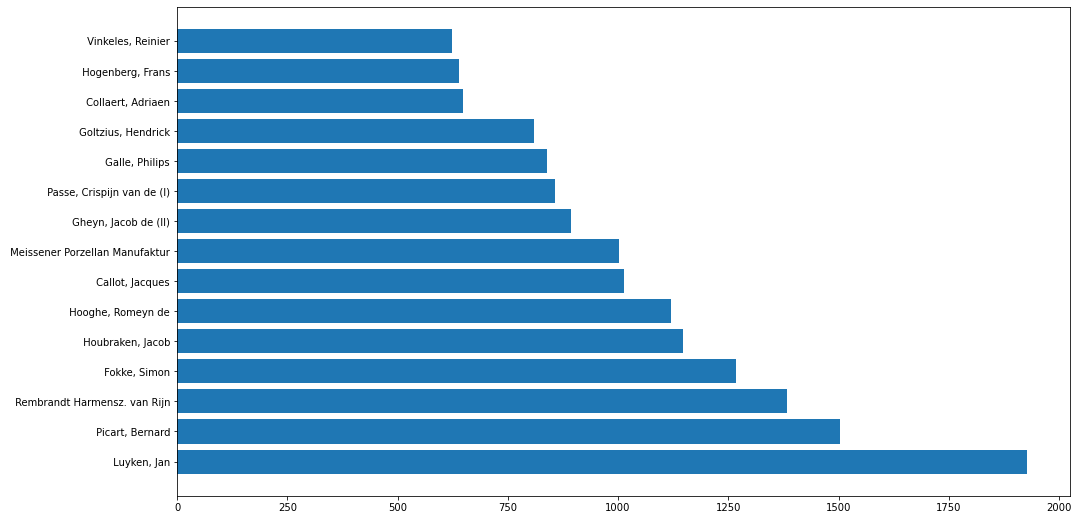

In [183]:
fig, ax = plt.subplots(figsize =(16, 9))
# plt.bar(selection['Creator'], selection['Title'])
ax.barh(grouped['Creator'][:15], grouped['Title'][:15])
plt.show()

In [186]:
grouped[grouped['Title'] >= 10].sum()

Creator     Luyken, Jan Picart, Bernard Rembrandt Harmens...
Title                                                  82620
dtype: object